# Capstone Project: Unsupervised Topic Modeling

## Table of Contents

- [Overview](#overview)<br>
- [Installation](#installation)<br>
- [Dataset](#dataset)<br>
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
- [Unsupervised Topic Modeling](#unsupervised-topic-modeling)<br>
- [Preprocessing](#pre-processing)<br>
- [Modeling](#dataset)<br>
- [Evaluation Metric](#evaluation-metric)<br>
- [Model Tunning](#model-tunning)<br>
- [Results interpretation](#results-interpretation)<br>
- [Final Selections](#final-selection)<br>
- [Extras & Concluding](#conclusions)
- [References](#references)<br>

#### Overview

Welcome to my notebook where I will be performing a detailed data analysis, and dive into the implementation of topic modeling algorithms. In addition, I will also be evaluating and fine-tuning the model, followed by sharing the full comparison results. For more details you can refer to this blog post on Meduim written by me.

#### Installation 

In [2]:
# download these packages first 
import nltk
nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arwao\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
# import libraries
import pandas as pd
import numpy as np
import ast
import re
import warnings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
from collections import Counter
%matplotlib inline


## Dataset

The dataset involves 190k+ Medium Articles collected from Medium website. <br>
 You can find the same dataset <a href='https://www.kaggle.com/datasets/fabiochiusano/medium-articles?resource=download'>here on Kaggle</a>.

<b> Data description </b> 

- title (str): Article title.
- text (str): Article full text.
- url (str): Article URL.
- authors (list of list of str): Author name.
- timestamp (str): datetime of the published article.
- tags (list of list of str): List of tags associated to the article.


In [4]:
# exploring the dataset
articles = pd.read_csv('medium_articles.csv')
articles.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


In [5]:
articles.shape[0]

192368

This dataset contains more than 19,000 000 articles. 

In [6]:
# Check for duplicate articles using URL
articles['url'].duplicated().sum()

0

In [7]:
# check for null values
articles.isnull().sum()

title        5
text         0
url          0
authors      0
timestamp    2
tags         0
dtype: int64

## Explanatory data analysis (EDA)

Large datasets are a rich source of hidden patterns in data. Even though it would be more ideal to use distributed computing platform such as Apache Spark to deal with the pre-processing, modeling, evaluation; the aim of this notebook is to test different algorithms on a considerably large corpus (not the whole dataset). So we're only going to take an overview of the dataset and provide some descriptive analysis through trying to answer these 3 questions: 

1. What are the most common topics in the dataset?
2. What is the distribution of the collected articles?
3. Top writers according to the data.

This section involves data wrangling, anomaly detection, data visualization.


### Q1: Most common topics in the dataset 

In [84]:
articles['tags'][3]

"['Health', 'Neuroscience', 'Mental Health', 'Psychology', 'Science']"

In [85]:
def getListValues(col, df=articles):
    '''
    Description:
    This function gets the values of a column in a pandas dataframe as a list of lists.
    
    INPUT:
    col - (str) column name as a string
    df - (pandas dataframe, optional) the original dataframe to extract values from.
    
    OUTPUT:
    groupedList - (list) a list of lists containing the values of the specified column for each row.
    
    '''

    # str to list to list object
    list = lambda x: ast.literal_eval(x)

    # apply to all rows
    df[col] = df[col].apply(list)

    # column values to a list of lists
    groupedList = df[col].values.tolist()

    return groupedList

In [86]:
# make list of lists
tags_list = getListValues('tags')
tags_list[:5]

[['Mental Health', 'Health', 'Psychology', 'Science', 'Neuroscience'],
 ['Mental Health', 'Coronavirus', 'Science', 'Psychology', 'Neuroscience'],
 ['Biotechnology', 'Neuroscience', 'Brain', 'Wellness', 'Science'],
 ['Health', 'Neuroscience', 'Mental Health', 'Psychology', 'Science'],
 ['Brain', 'Health', 'Development', 'Psychology', 'Science']]

In [87]:
# return unique tags
unique_values = list(set().union(*tags_list))
len(unique_values)

78638

There is around 78000 unique tags, for better visualization we're going to display the top 25 tags

In [88]:
def countValues(lists):
    '''
    Description:
    It gets the count of each value in a list of lists.
    
    INPUT:
    lists - (list) a list of lists containing values to be counted.
    
    OUTPUT:
    counts - (pandas dataframe) a dataframe containing the count of each unique value.

    '''

   # count number of tags for all lists
    flat_list = [x for sublist in lists for x in sublist]

    # create new dataframe
    counts = pd.DataFrame({'counts': flat_list})

    return counts

In [89]:
#store count of tags
tags_num = countValues(tags_list)

In [90]:
def top_n_tags(n , tags=tags_num):
    '''
    Description:
    Return a list of top n tags in the dataset.

    INPUT:
    tags - pandas dataframe of tags and thier count.
    n - (int) number of tags you want to retrive.

    OUTPUT:
    top_tags - pandas dataframe of n tags and count.
    
    '''
    top_tags = tags.value_counts()[:n]
    return top_tags

In [91]:
# store top 25 tags
top25 = top_n_tags(25)

In [92]:
type(top25.index)

pandas.core.indexes.multi.MultiIndex

In [93]:
# changing the format from multi-index to index
index = top25.index.map(''.join)

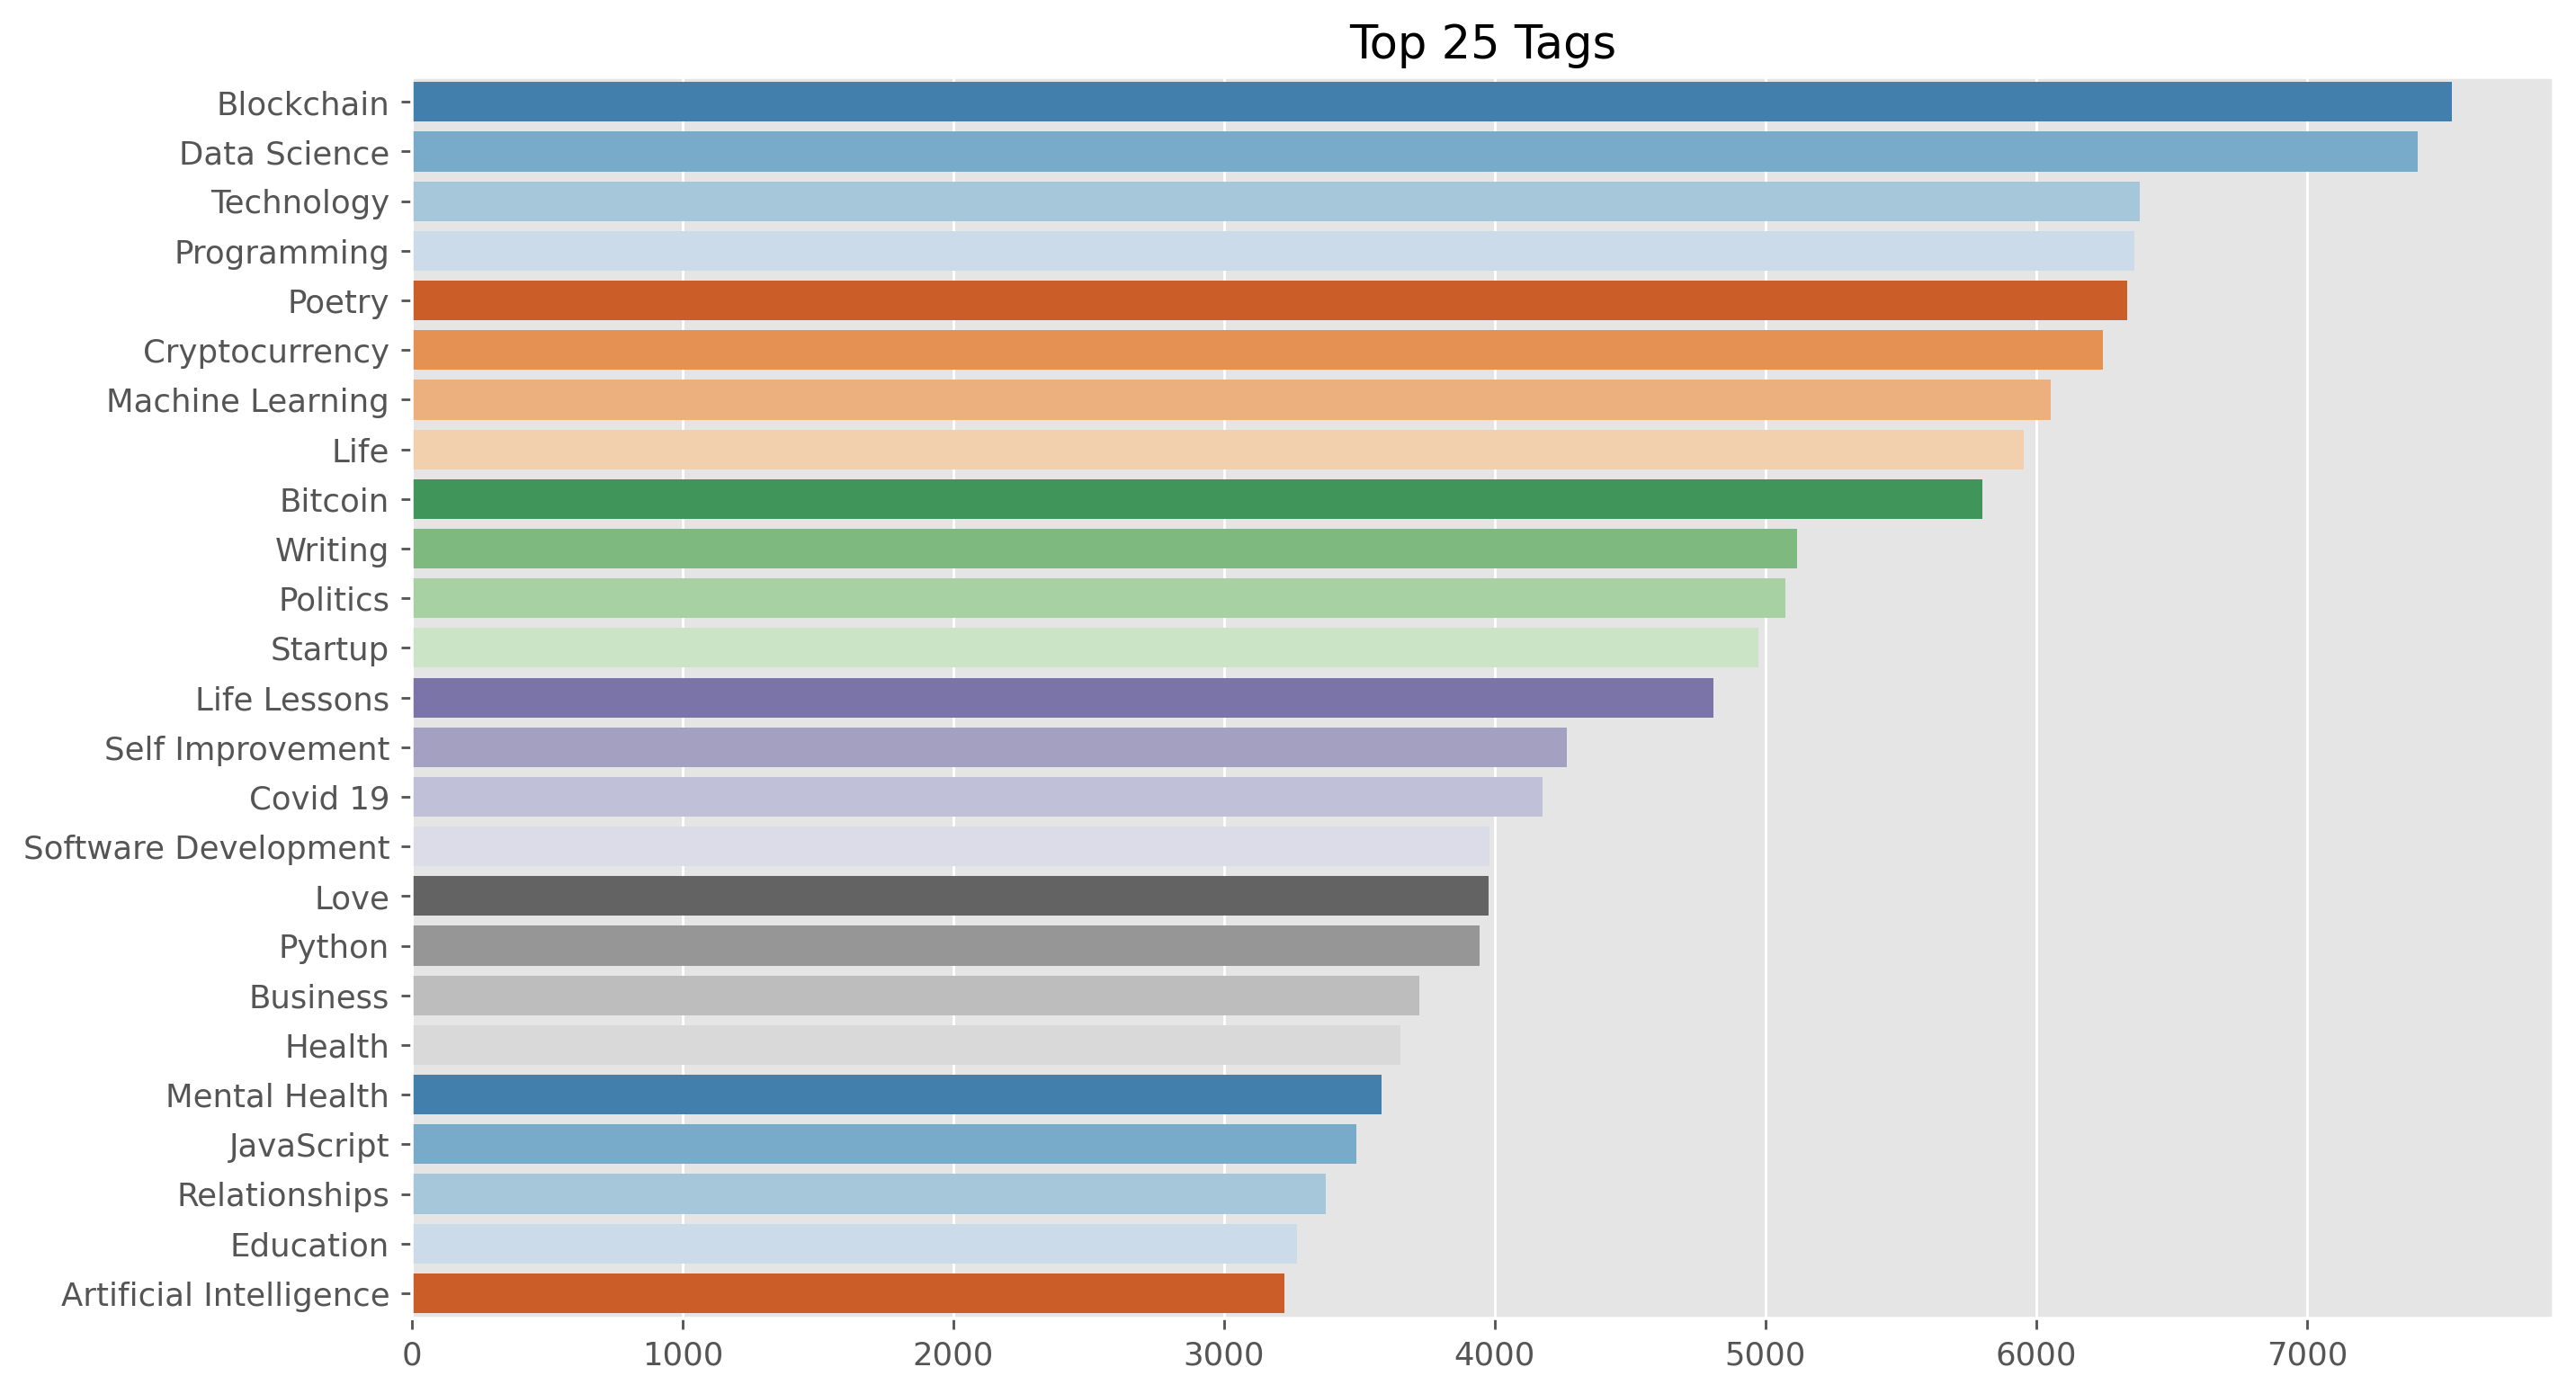

In [94]:
# plotting the results 
plt.style.use('ggplot')
figure(num=None, figsize=(12,7), dpi=256, facecolor='w', edgecolor='r')
plt.title('Top 25 Tags') #change to top n tags 
sns.barplot(x = top25.values , y = index , palette = 'tab20c')
plt.show()

The dataset top tags are mostly related to technology with some board categories such as life, health, education etc..

### Q2: Distribution of collected articles dates

In [95]:
# creating a copy 
df = articles.copy()

In [96]:
# getting the date only from strings
df['timestamp'] = df['timestamp'].str[:10]

In [97]:
df['timestamp'][:5]

0    2020-12-26
1    2020-09-23
2    2020-10-10
3    2020-12-21
4    2020-02-26
Name: timestamp, dtype: object

In [98]:
# str to datetime
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

After visualizing the dates there were some anomalies detected and they must be handled properly.


In [99]:
df['timestamp'].dt.year.value_counts()

2020.0    115846
2021.0     32182
2019.0     26221
2018.0      9846
2017.0      4649
2016.0      2689
2015.0       636
2022.0       275
2030.0         5
2009.0         2
2011.0         1
1917.0         1
2014.0         1
1985.0         1
1987.0         1
1991.0         1
2025.0         1
1992.0         1
2077.0         1
2003.0         1
1941.0         1
1969.0         1
2034.0         1
2013.0         1
2012.0         1
Name: timestamp, dtype: int64

Some dates like 2034 or 1917 are clearly anamolies since the timestampe represent the date and time on which the article was published.

According to Wikipedia: "Medium is an American online publishing platform developed by Evan Williams and launched in August 2012."

In [100]:
# filter df based on date range
start_date = '2012-08-01'
end_date = '2022-12-31'
criteria = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
filtered_df = df.loc[criteria]

In [101]:
# grouping the dates by year and count the number of dates in each group
year_counts = filtered_df['timestamp'].dt.year.value_counts()
year_counts

2020    115846
2021     32182
2019     26221
2018      9846
2017      4649
2016      2689
2015       636
2022       275
2014         1
2013         1
2012         1
Name: timestamp, dtype: int64

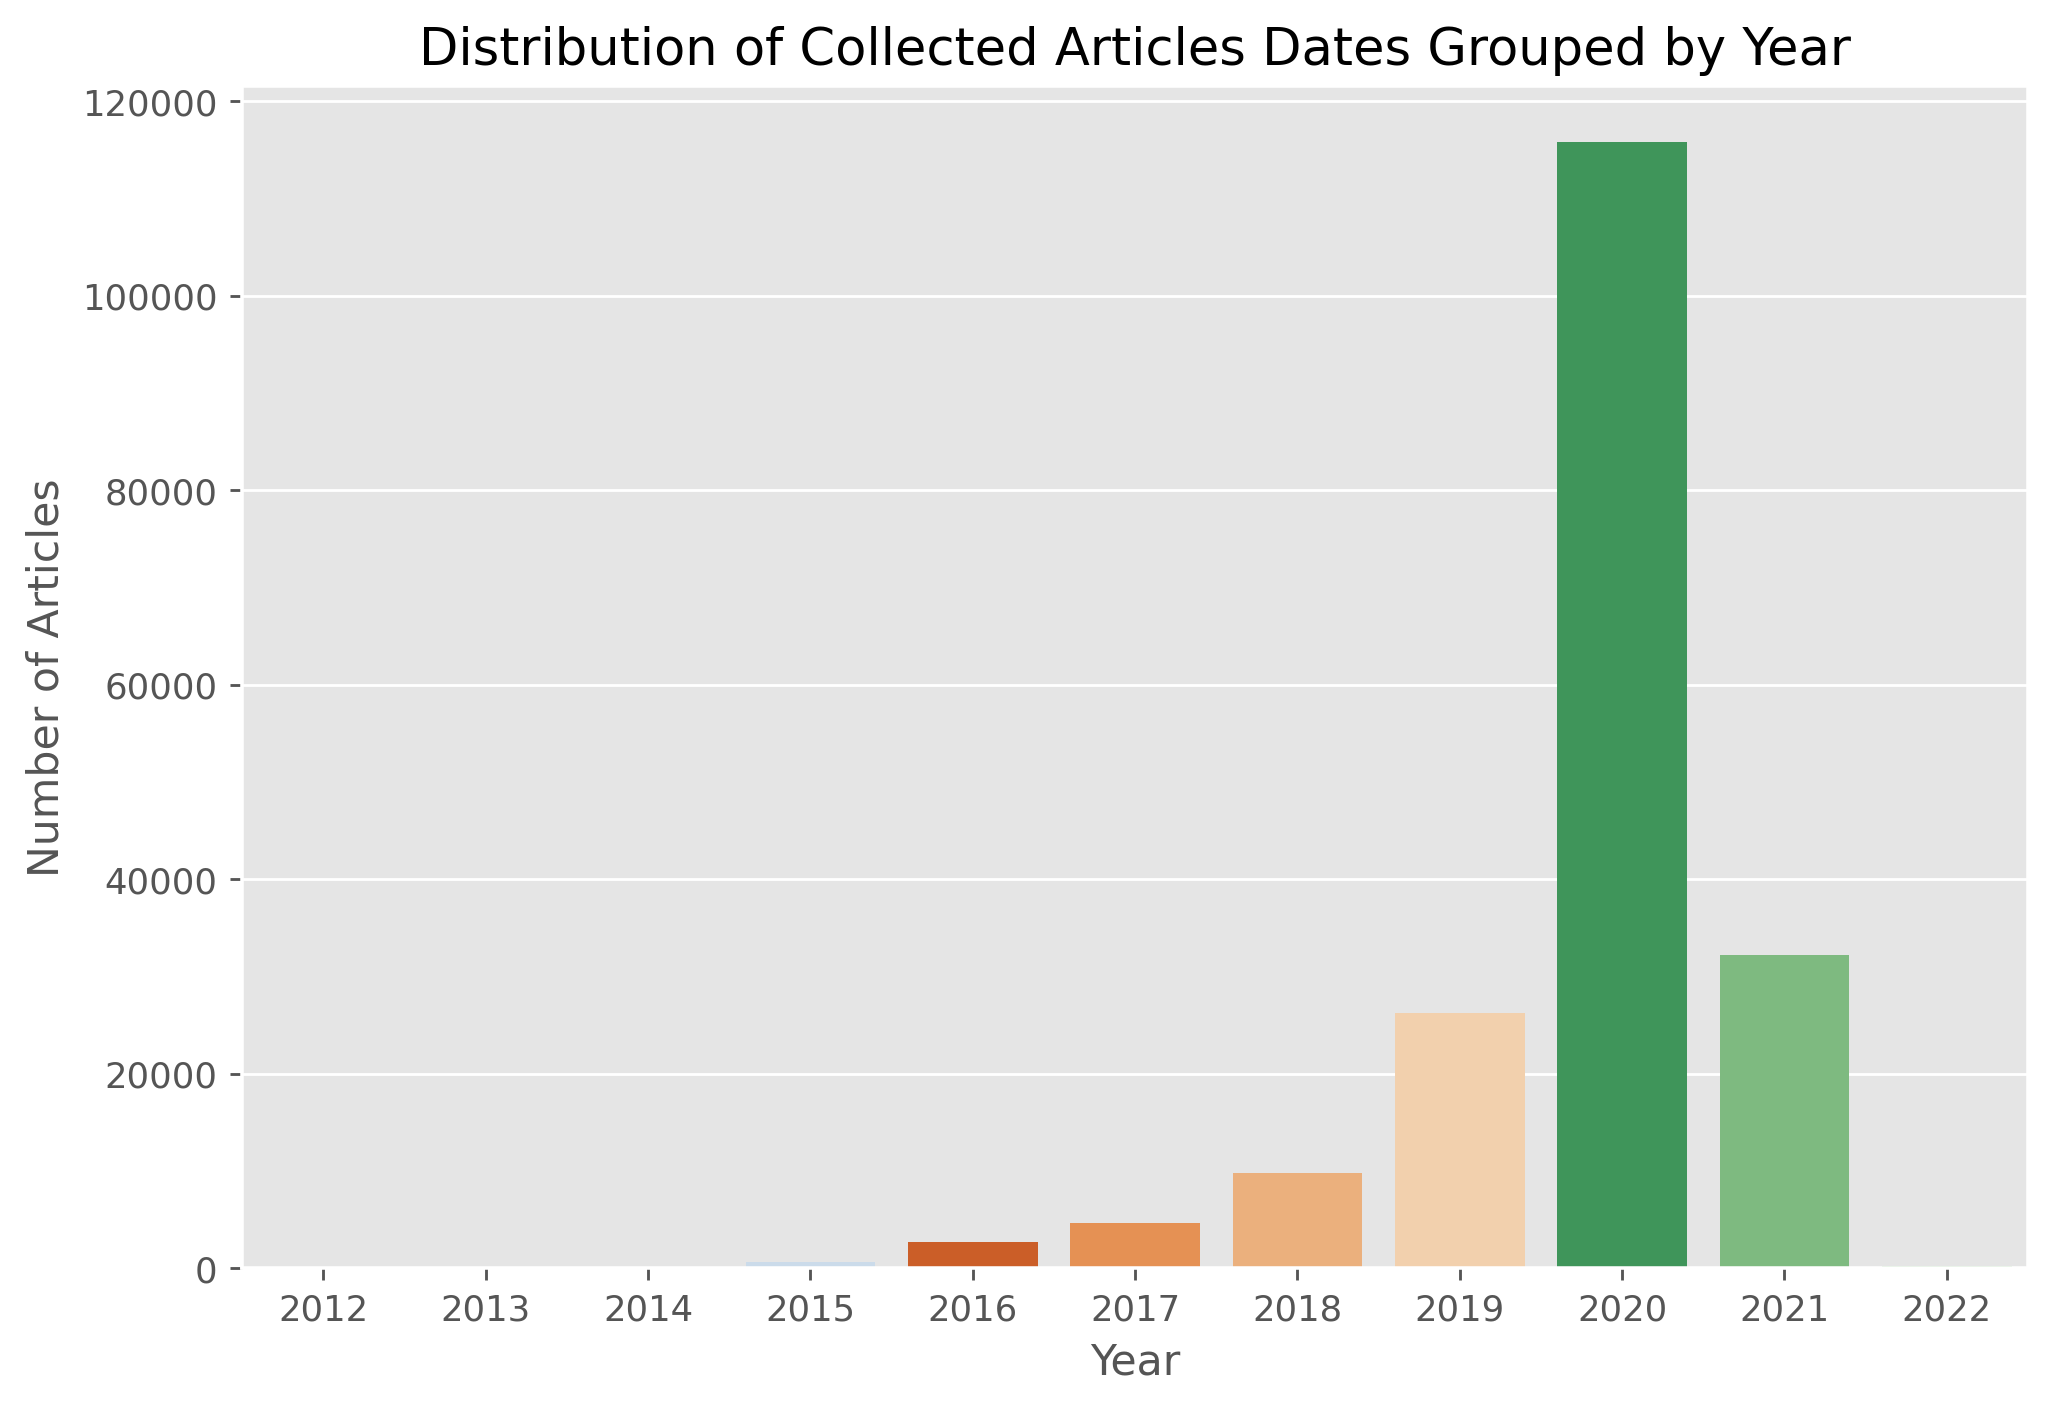

In [102]:
figure(num=None, figsize=(9,6), dpi=256, facecolor='w', edgecolor='r')
# Set the chart title and axis labels
plt.title('Distribution of Collected Articles Dates Grouped by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')


# Set the x-axis limits to match the range of the x values
plt.xlim(min(year_counts.index), max(year_counts.index))

sns.barplot(x = year_counts.index, y = year_counts.values , palette = 'tab20c')

plt.show()

### Q3: Top 10 Writers

This section involves some data wrangling, anomaly detection, and data visualization.

In [103]:
# get all authors
authors = getListValues('authors')
authors[:5]

[['Ryan Fan'], ['Simon Spichak'], [], ['Eshan Samaranayake'], ['Rishav Sinha']]

In [104]:
authors_count = countValues(authors)

In [105]:
top10 = authors_count.value_counts()[:10]
top10

counts              
Are You Syrious         206
John Au-Yeung           167
The Good Men Project    155
J.D. Harms              152
Scott Myers             143
Gaurav Shah             138
Tds Editors             124
Shamontiel L. Vaughn    122
Martino Pietropoli      115
James Finn              114
dtype: int64

In [106]:
index = top10.index.map(''.join)

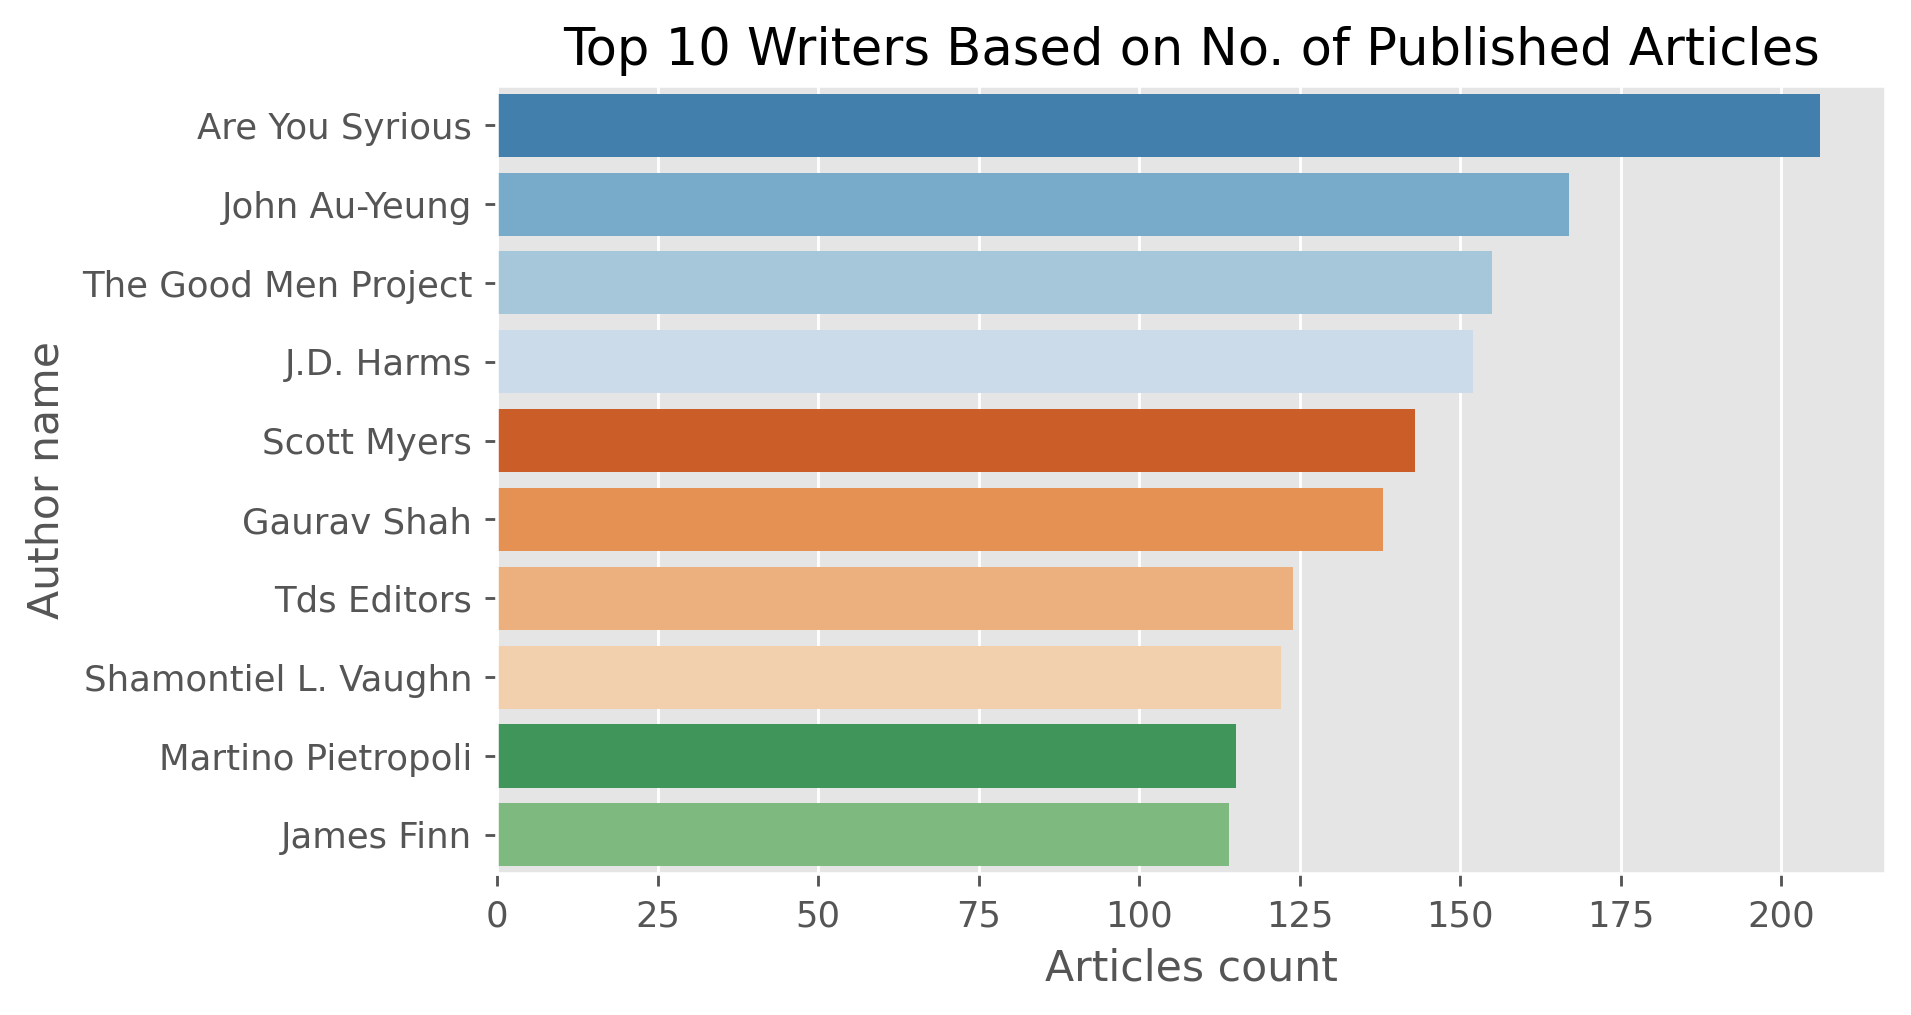

In [107]:
# plotting the results 
figure(num=None, figsize=(7,4), dpi=256, facecolor='w', edgecolor='r')

plt.title('Top 10 Writers Based on No. of Published Articles') 
plt.xlabel('Articles count')
plt.ylabel('Author name')

sns.barplot(x = top10.values , y = index , palette = 'tab20c')
plt.show()

## Unsupervised Topic Modeling

Topic modeling is task in natural language processing (NLP) aims to discover latent topics or themes in a collection of unstructured text data, without the need of any labeled data. The goal of topic modeling is to uncover the semantic structure of a corpus of text by identifying groups of words that mostly co-occur in the same context.

We will only use the dataset's 'text' column, which is the only column that contains unstructured text. Medium articles dataset has a very diverse collection of topics which I believe makes it better suited for tasks like topic modeling.  This will enable me to shed light on unsupervised learning and exploring a new exciting concept in NLP.

## Pre-processing


### 1. Data sampling

to handle a large corpus dataset we can resample the corpus size randomly
other approaches can be using PySpark or any a distributed computing platform

In [14]:
warnings.filterwarnings('ignore')

In [20]:
# sampling to 10.000 articles only
text = pd.read_csv('medium_articles.csv').sample(10000, random_state=10)
text[:3]

,title,text,url,authors,timestamp,tags
90936,To My Brother,To My Brother\n\n(original pictures: Brother a...,https://medium.com/illumination/to-my-brother-...,['Lyndsey Frondarina'],2020-12-19 04:14:48.316000+00:00,"['Illumination', 'Siblings', 'Suicide Awarenes..."
104173,"Suicide, Facts, and Depression",Thoughts of suicide is most likely the worst t...,https://medium.com/@humanityprime-seo/suicide-...,['Humanity Prime'],2020-12-10 14:34:03.862000+00:00,"['Suicide Squad', 'Suicide Awareness', 'Suicid..."
78134,Will Social Commerce become a next big thing?,"As the year is coming to an end, not only can ...",https://medium.com/fintechonthego/will-social-...,['Mai Nguyen Q'],2020-12-26 15:28:49.299000+00:00,"['Social Commerce', 'Payments', 'Ecommerce', '..."


### 2. Tokenization

In [21]:
def tokenize(text):
    '''
    Description: This function will tokenize, 
    clean the text, remove non-english words, 
    and return words to its roots.
  
    INPUT:
    text (str): text in str format.
    
    OUTPUT:
    str: clean and tokenized text. 
    
    '''
    # normalize text
    text = text.lower() 
    #clean text
    text = re.sub(r'http\S+|https\S+|www\S+|[^0-9A-Za-z \t]', ' ', text)
    #tokenize text using this function
    words = word_tokenize(text) 
    #store stop words 
    stop_words = stopwords.words('english') 
    #remove all stop words
    new_text = [x for x in words if x not in stop_words]
    #lemming
    lemmed = [WordNetLemmatizer().lemmatize(x) for x in new_text]

    return lemmed

In [23]:
text['tokenized'] = text['text'].apply(tokenize)

In [24]:
text['tokenized'][:2]

90936     [brother, original, picture, brother, used, wi...
104173    [thought, suicide, likely, worst, type, depres...
Name: tokenized, dtype: object

## Modeling

<b> Algorithm Selection </b> <br> 
There are several topic modeling algorithms, in this compartive analysis we're going to test 3 different algorithms which are:
1. Latent Dirichlet Allocation (LDA)
2. Non-negative Matrix Factorization (NMF)
3. Linear Dimensionality Reduction (LSA) using Singular Value Decomposition (SVD)

### Evaluation metric

In unsupervised topic modeling, there is no clear "correct" labeling of topics, so it is difficult to evaluate the performance of models using traditional classification metrics.<br><br> One common metric for evaluating topic models is <b>coherence</b>, which measures the degree to which the top words in a topic are semantically related. A higher coherence score indicates that the topic contains words that are more closely related in meaning. <br><br> We will be using the topic coherence pipeline of <a href="https://radimrehurek.com/gensim/models/coherencemodel.html">Gensim library</a>.

In [45]:
tokenized_text = text['tokenized'].to_list()

# Create a Gensim Dictionary object from the feature names
gensim_dict = corpora.Dictionary(tokenized_text)

In [60]:
def get_coherence_score(model, topics, feature_names=tokenized_text, gensim_dict=gensim_dict):
    '''
    Description: This function will calculate the coherence 
    score of a topic model using Gensim CoherenceModel.
    
    INPUT:
        - model: A trained topic model.
        - topics (list of list of str) : each topic relevant topics.
        - feature_names (list of list of str): list of tokenized text.
        - gensim_dict: A Gensim dictionary to map to original words.
        
    OUTPUT:
        - coherence_score (float): coherence score of the topic model.
    '''

    coherence_model = CoherenceModel(
        model=model,
        topics=topics,
        texts=feature_names,
        dictionary=gensim_dict,
        coherence="c_v", 
    )
    coherence_score = coherence_model.get_coherence()

    return coherence_score

### Visualizing top relevant words

In [96]:
def visualize_top_words(word_lists, title):
    '''
    Description: Display figures of the most relevant words
    in each topic as a word cloud.

    INPUT:
        - word_lists (list of lists of str): words associated with each model.
        - title (str): A string representing the title of the plot.

    OUTPUT:
        - A plot of the most relevant words for each topic.

    '''
    
    # set figure size and layout
    num_plots = len(word_lists)
    num_rows = (num_plots + 4) // 5
    fig, axs = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, num_rows*4))
    axs = axs.flatten()

    # loop through each word list and create a word cloud
    for i, word_list in enumerate(word_lists):

        # word cloud for each topic
        wordcloud = WordCloud(width=800,
                              height=800, 
                              background_color='white',
                              colormap='tab20c').generate_from_text(' '.join(word_list))
        
        # adding black borders to the subplots
        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].set_frame_on(True)
        axs[i].spines['top'].set_color('black')
        axs[i].spines['bottom'].set_color('black')
        axs[i].spines['left'].set_color('black')
        axs[i].spines['right'].set_color('black')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        
        # add a title and place it below each figure
        axs[i].text(0.5, -0.1, f'Topic {i+1} most relevant words',
                    size=12, ha='center', transform=axs[i].transAxes)
    
    # plot the title
    fig.suptitle(title, fontsize=24)
    
    # remove any extra subplots
    for i in range(num_plots, len(axs)):
        axs[i].axis('off')
    
    # display and save the plot
    plt.savefig(f'{title}.png', dpi=1200, format='png', bbox_inches='tight')
    plt.show()

### Topic modeling pipeline

In [76]:
def topic_modeling_pipeline(df=text):
    '''
    Description: topic modeling pipeline for 3 algorithms.

    INPUT:
        - df(dataframe): A dataframe containing text data.

    OUTPUT:
        - df_results(dataframe): A dataframe containing the results of each model and its coherence score.

    '''
    # set vectorizer to custom function
    vectorizer = CountVectorizer(tokenizer=tokenize)
    num_topics = 10 #to reduce computational time 10 topics are enough for comparison
    num_top_words = 15 # number of words to be visualized

    # the three models to be compared
    models = [('LDA', LatentDirichletAllocation(n_components=num_topics)),
              ('NMF', NMF(n_components=num_topics)),
              ('LSA', TruncatedSVD(n_components=num_topics))]

    results = [] # empty list to store scores

    # pipeline for each model 
    for name, model in models:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('model', model)
        ])

        # only pass X, there is no Y 
        pipeline.fit(df['text'])

        topics = [] # empty list of topics for each model

        feature_names = vectorizer.get_feature_names_out() # tokenized text
        # loop through every topic and get top 15 words
        for topic_idx, topic in enumerate(model.components_):
            topic_tokens = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
            topics.append(topic_tokens)

        # calculate coherence score 
        coherence = get_coherence_score(model, topics)

        # append scores to results list
        results.append((name, coherence))

        # visualizing top words for each topic
        visualize_top_words(topics, f'Figures of words associated with each topic for {name} Model')
        print()

    # stroring the results in a dataframe
    df_results = pd.DataFrame(results, columns=['Model', 'Coherence Score'])

    return df_results

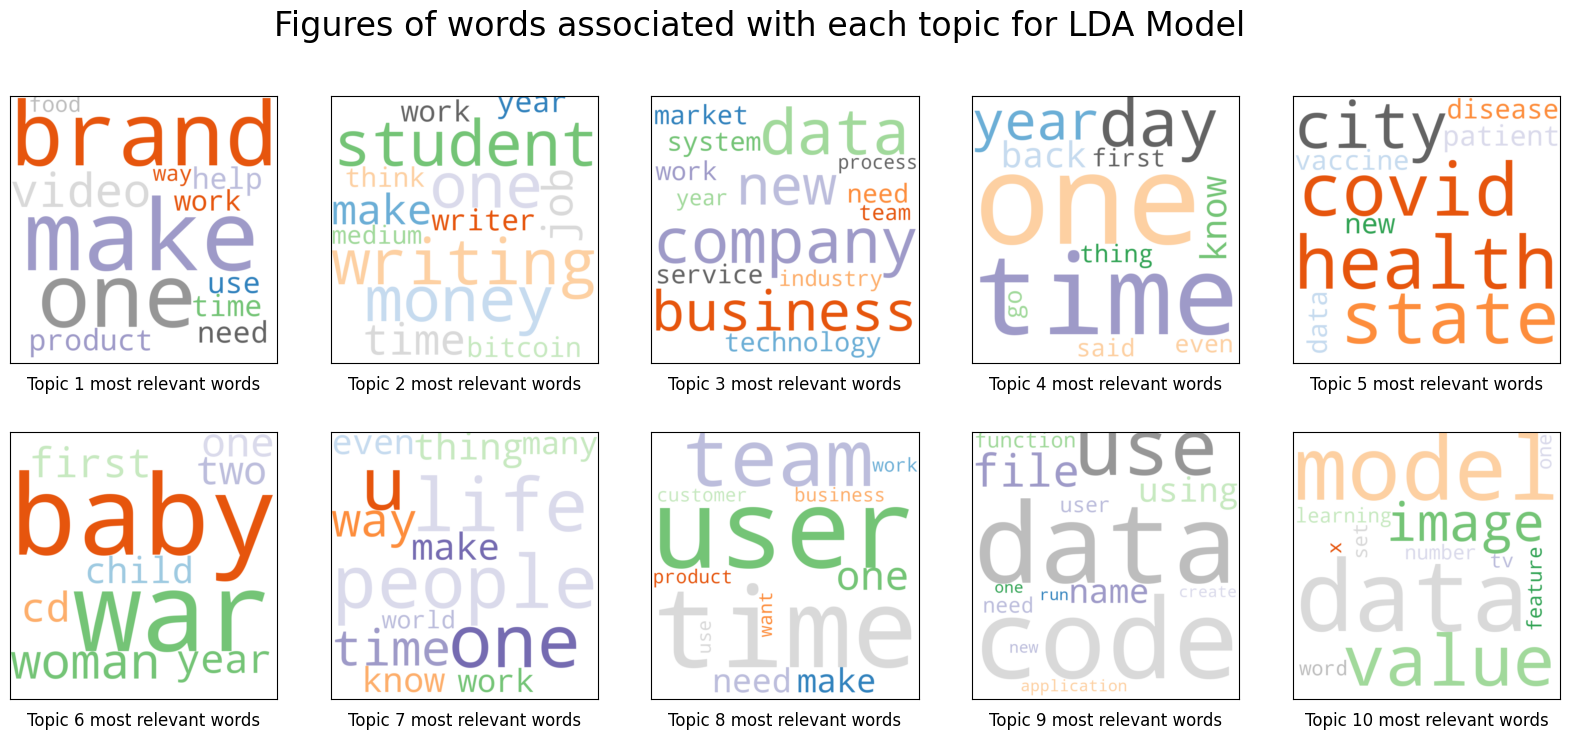

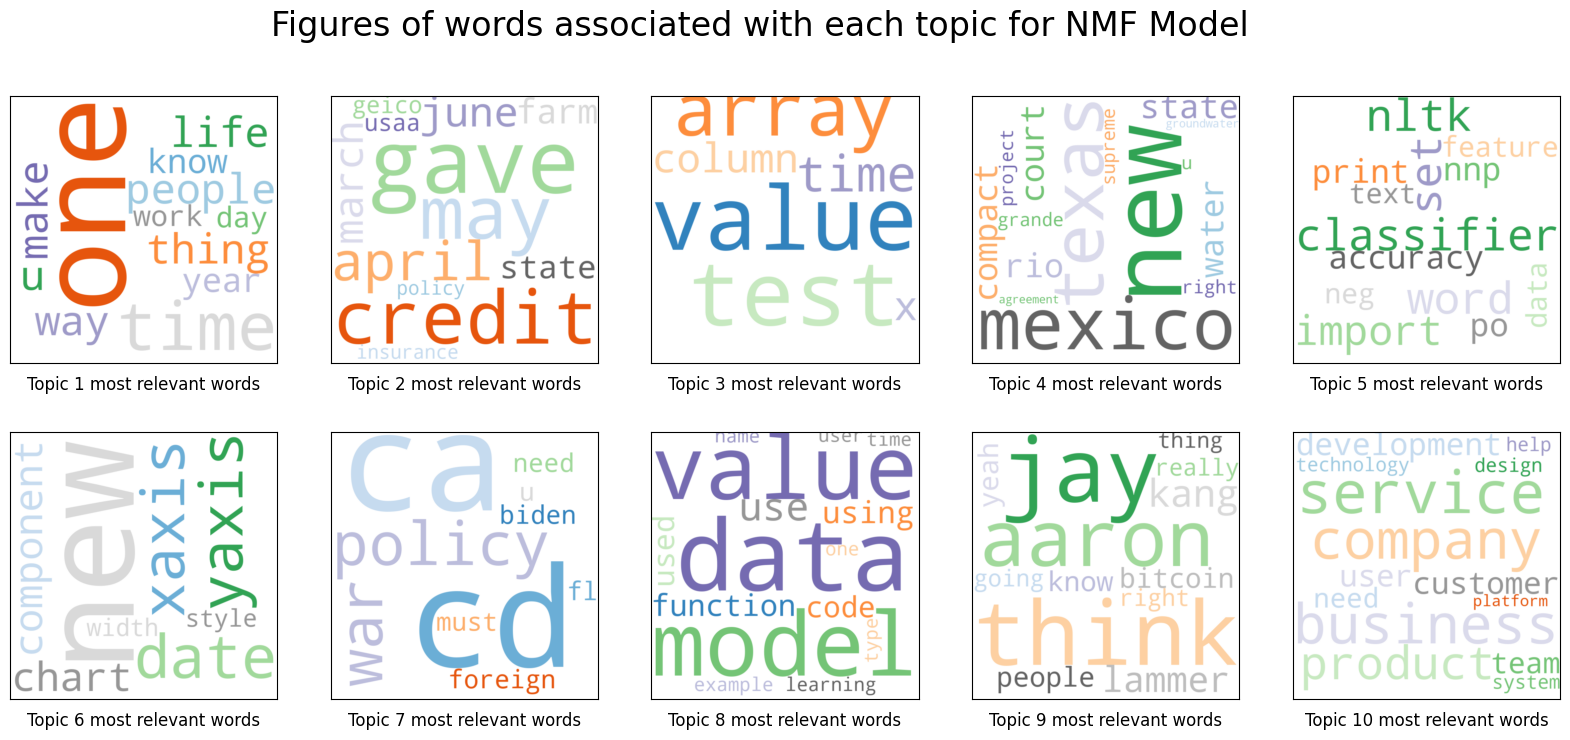

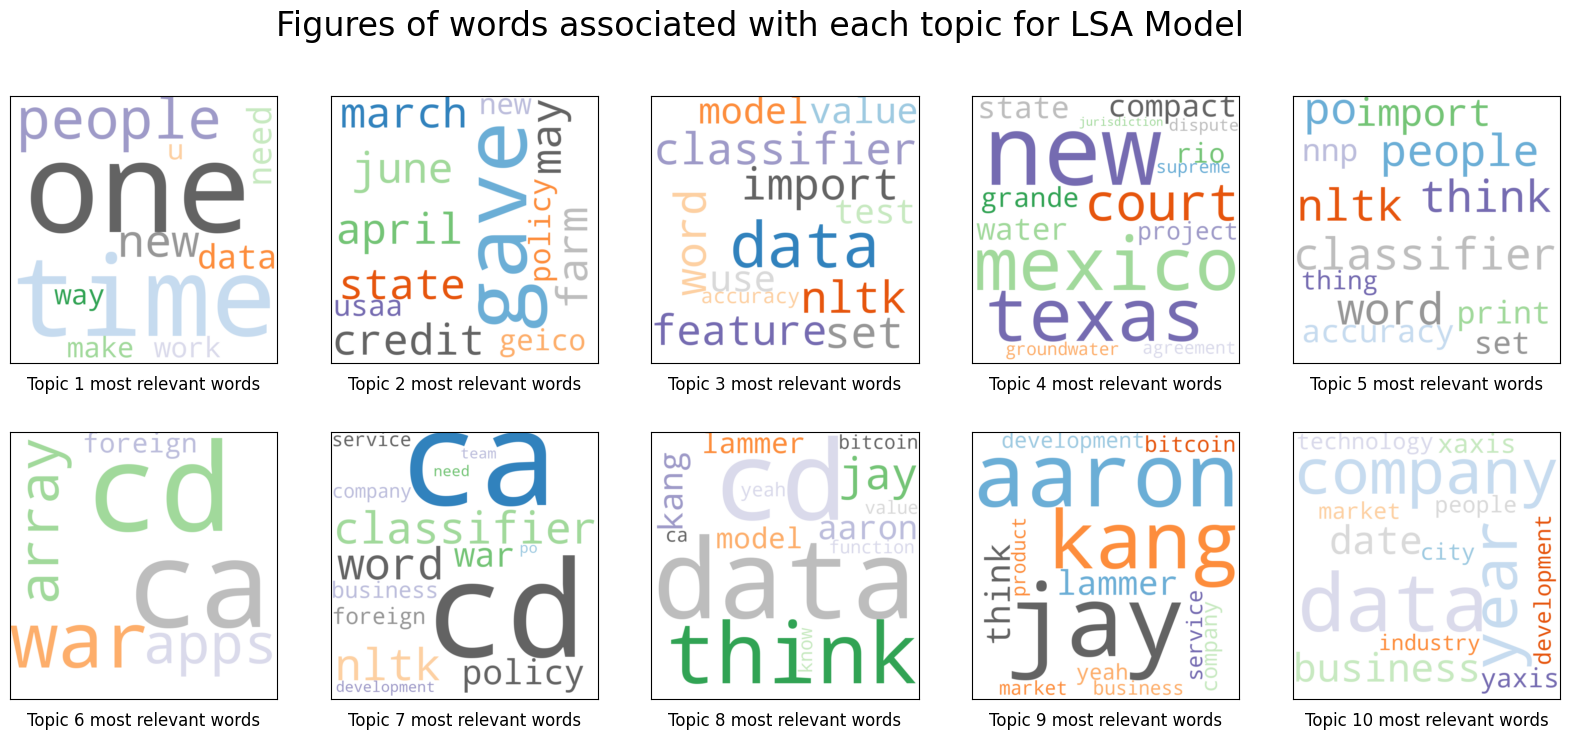

In [77]:
results = topic_modeling_pipeline()

### Models results

In [69]:
results

,Model,Coherence Score
0,LDA,0.443777
1,NMF,0.581182
2,LSA,0.467712


The NMF topic model showed higher coherence score, so we will be moving with it for the remaining steps.

## Model Tunning

In [76]:
def nmf_topic_comparison(num_topics_list, df=text):
    '''
    Description: testing performance of  NMF model for different numbers of topics.

    INPUT:
        - num_topics_list(list of int): A  representing the different numbers of topics to be evaluated.
        - df(dataframe): A dataframe containing text data.

    OUTPUT:
        - df_results(dataframe): results of number of topics and its corresponding coherence score.

    '''
    vectorizer = CountVectorizer(tokenizer=tokenize)
    num_top_words = 15
    results = [] #empty list for scores
    # loop based on number of topics
    for num_topics in num_topics_list:
        nmf_model = NMF(n_components=num_topics)
        pipeline = Pipeline([('vectorizer', vectorizer), ('model', nmf_model)])

        # train the model
        pipeline.fit(df['text'])

        topics = [] # empty list for topics

        feature_names = vectorizer.get_feature_names_out()  # tokenized text
        
        for topic_idx, topic in enumerate(nmf_model.components_):
            topic_tokens = [feature_names[i] for i in topic.argsort()[: -num_top_words - 1 : -1]]
            topics.append(topic_tokens)

        # calculate coherence score 
        coherence = get_coherence_score(nmf_model, topics)

        # append the results to the list
        results.append((num_topics, coherence))

    # store results in a dataframe
    df_results = pd.DataFrame(results, columns=['No. of Topics', 'Coherence Score'])

    # return the dataframe
    return df_results


In [77]:
scores = nmf_topic_comparison([2,4,6,8,10,12,14,16,18,20])

''

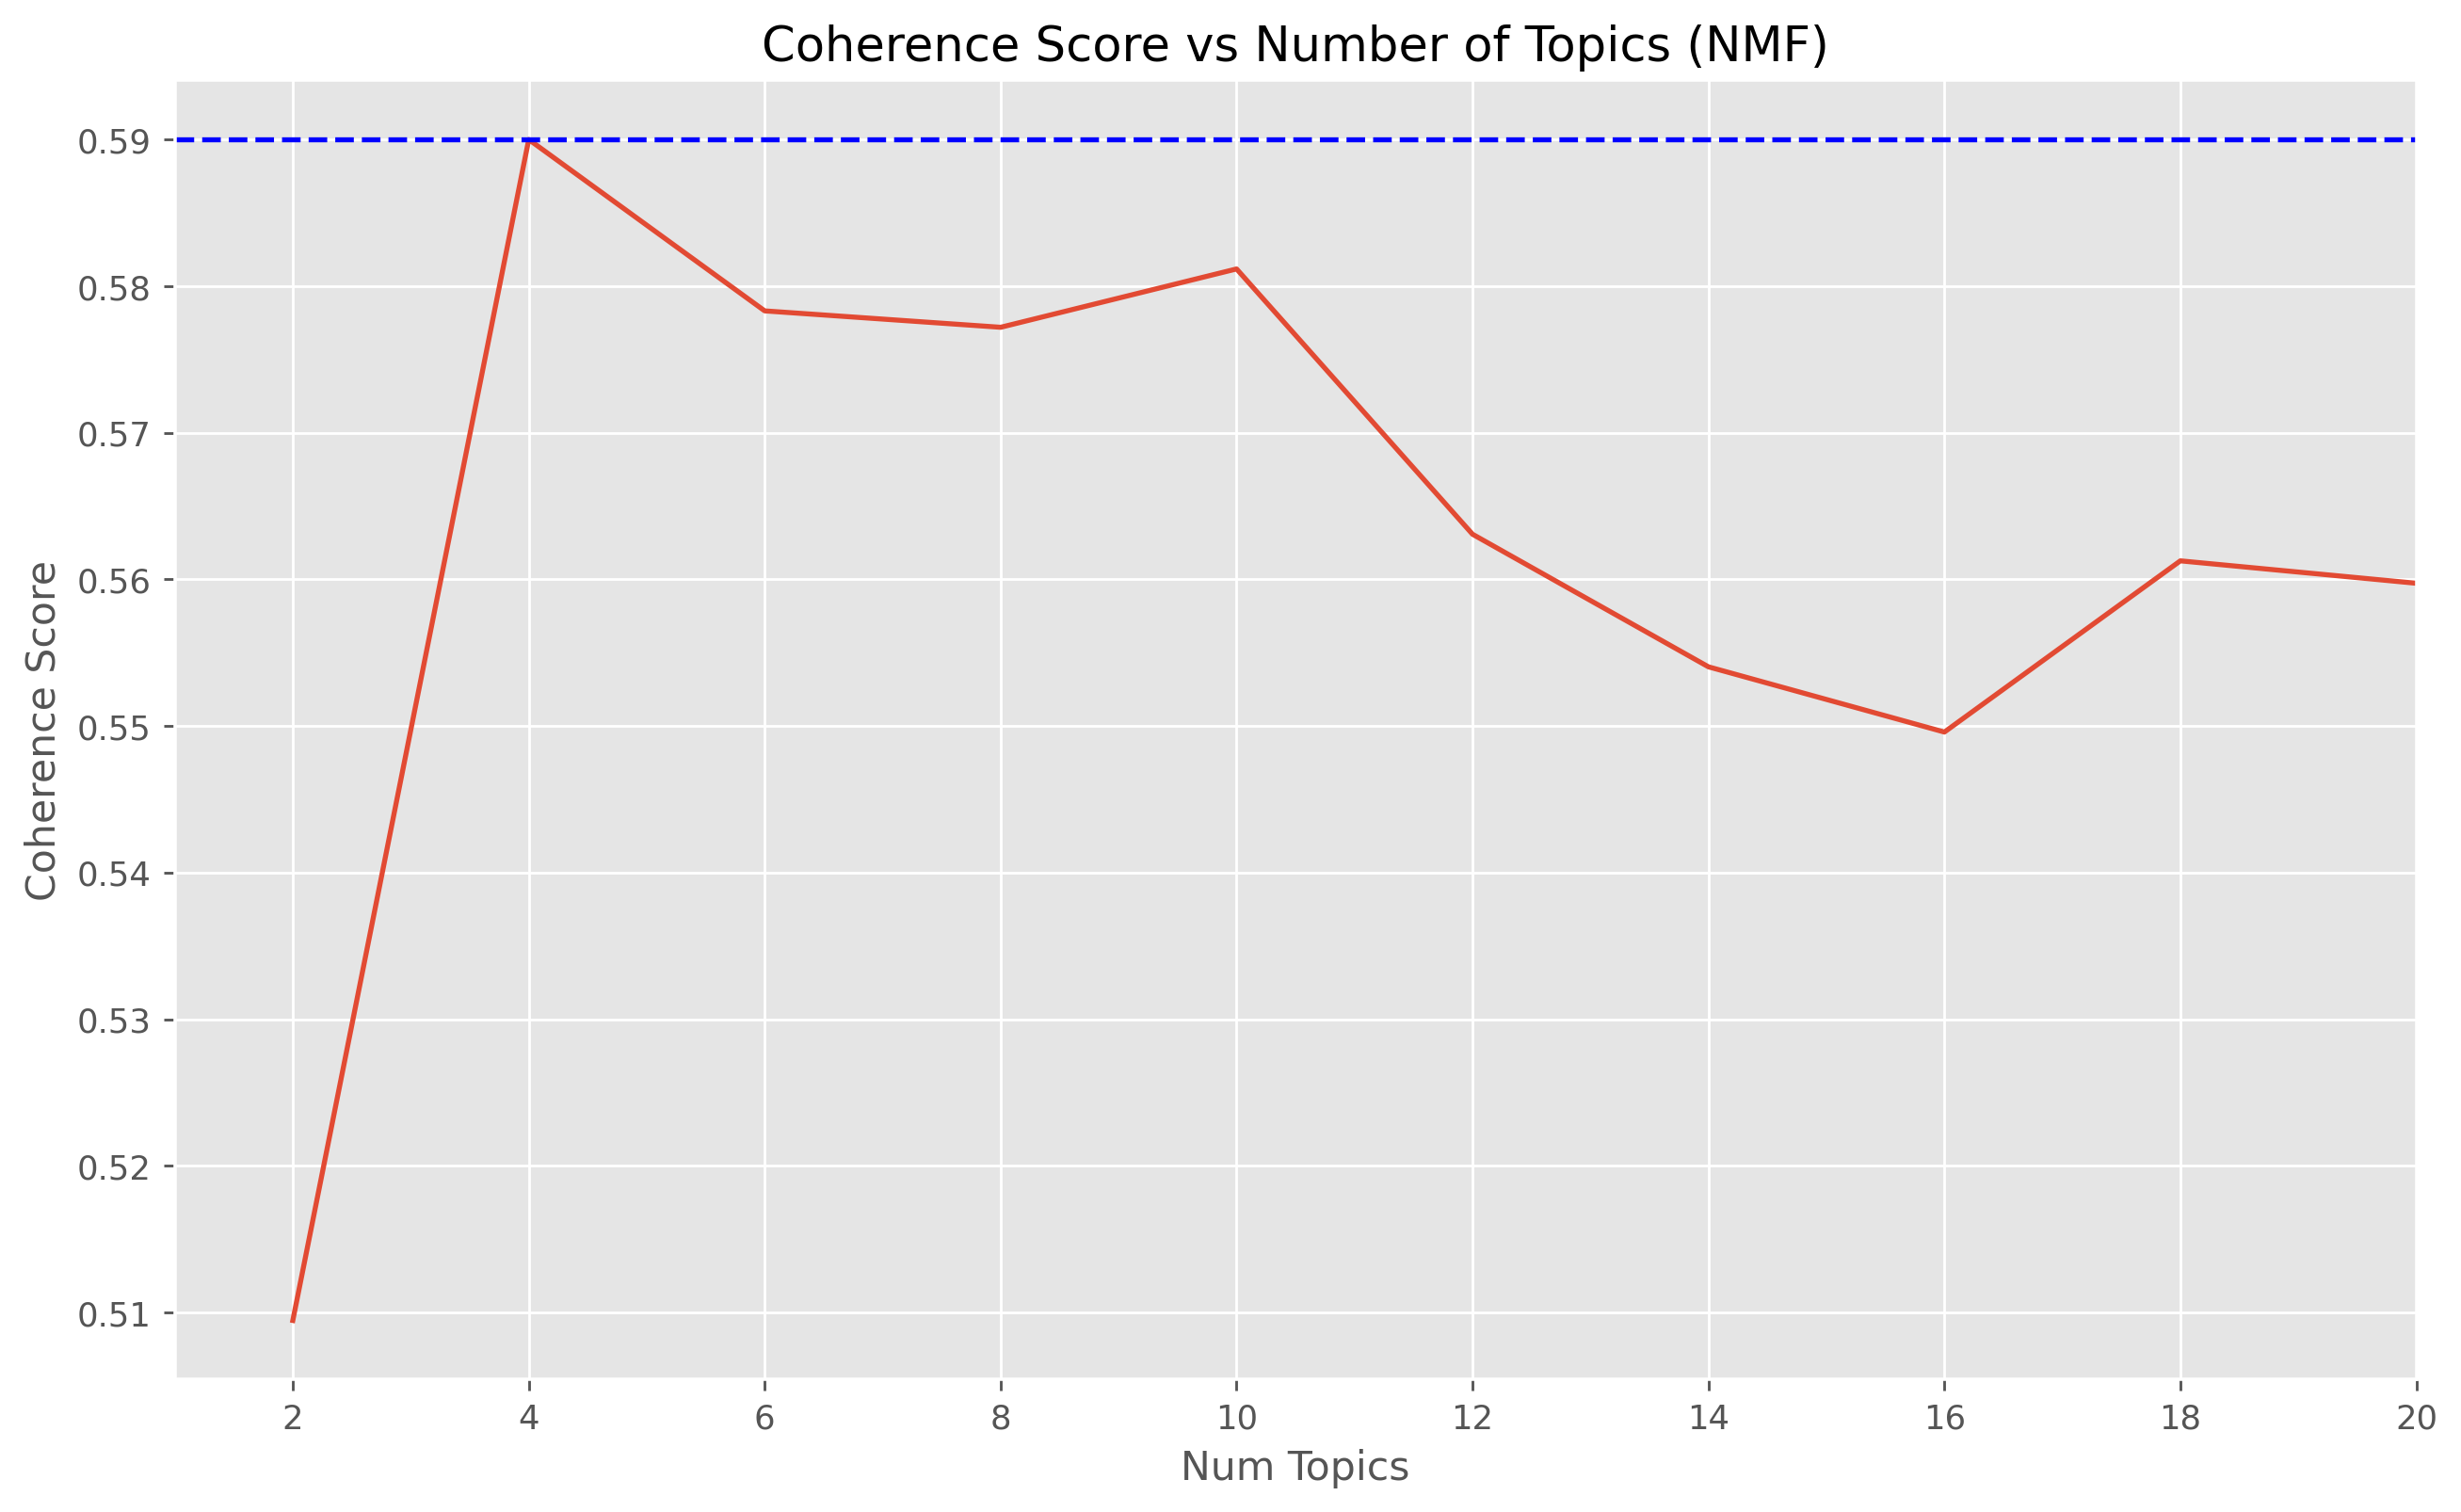

In [128]:
# plot results
plt.figure(num=None, figsize=(12,7), dpi=256, facecolor='w', edgecolor='r')
plt.title('Coherence Score vs Number of Topics (NMF)')

sns.lineplot(x=scores['No. of Topics'], y=scores['Coherence Score'], palette='tab20c')

# add a horizontal line on the maximum coherence score
max_score = scores['Coherence Score'].max()
plt.axhline(y=max_score, color='b', linestyle='--')

plt.xlim(1, 20) # set the x-axis limits to start at 2

# set the x-tick locations to even numbers only
even_ticks = np.arange(2, max(scores['No. of Topics']) + 1, 2)
plt.xticks(even_ticks)
;

## Results interpretation

In this case, the algorithm was run for different numbers of topics, ranging from 2 to 20. <br> The coherence scores for each number of topics are shown in the Figure.

Based on the coherence scores, it appears that the most coherent number of topics is 4, with a coherence score of 0.590.<br> However, other numbers of topics, such as 10 and 18, also have relatively high coherence scores.

## Final selection 

Considering that there are around 10,000 articles in the dataset
for subjects to be generalized, <br> 4 topics is a very minimal number.
10 topics would be ideal and still get a high coherence scores. 

In [73]:
vectorizer = CountVectorizer(tokenizer=tokenize)
matrix = vectorizer.fit_transform(text['text'])

# create an NMF topic model using 10 topics
model = NMF(n_components=10, alpha_H=0.1) 
model.fit(matrix)
model.get_feature_names_out()

array(['nmf0', 'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5', 'nmf6', 'nmf7',
       'nmf8', 'nmf9'], dtype=object)

In [95]:
model.get_params()

{'alpha_H': 0.1,
 'alpha_W': 0.0,
 'beta_loss': 'frobenius',
 'init': None,
 'l1_ratio': 0.0,
 'max_iter': 200,
 'n_components': 10,
 'random_state': None,
 'shuffle': False,
 'solver': 'cd',
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
# to save the model uncomment the lines and import pickle 
# file = 'NMF.sav'
# pickle.dump(model, open(file, 'wb'))

## Conclusion

Based on the analysis for three algorithms - LDA, NFM, and LCA - to perform topic modeling, it was found that NFM showed the best results and coherence scores for 10 diffrent topics. NFM showed great results on large corpus although it is known to perform well on small to medium-sized datasets.


# References

- <a href="https://radimrehurek.com/gensim/index.html">Gensim Topic Modling for Human </a>
- <a href="https://scikit-learn.org/stable/index.html">scikit-learn Machine Learning in Python</a>
- <a href="https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0">Evaluate Topic Models: Latent Dirichlet Allocation (LDA) by Shashank Kapadia </a>
- <a href="https://towardsdatascience.com/topic-modeling-for-the-new-york-times-news-dataset-1f643e15caac">Topic Modeling for The New York Times News Dataset</a>
- <a href="https://towardsdatascience.com/topic-modelling-f51e5ebfb40a">The Complete Practical Guide to Topic Modelling</a>
- Meduim dataset on <a href="https://www.kaggle.com/datasets/fabiochiusano/medium-articles?resource=download">Kaggle</a>